<center><img src="images/header1.png" width=400></center>

<h1><center>Основы машинного обучения</center></h1>
<hr>
<h2><center>Методы обучения без учителя: Домашняя работа</center></h2>

Правила:

* Отчеты принимаются до 23:59 29 апреля. Вы должны залить ваш ноутбук в [colab](https://colab.research.google.com) и дать на него ссылку в форме сдачи ДЗ на портале
* Работоспособность будет проверяться в коллабе. Это значит что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/ML2023/tree/main/lecture06/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

<ipython-input-2-6b0756f022bb>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [ ]:
!mkdir ./data
!wget https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture06/data/sign_database.csv -O ./data/sign_database.csv
!wget https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture06/data/sign_classes.csv -O ./data/sign_classes.csv

mkdir: cannot create directory ‘./data’: File exists
--2023-04-28 18:28:02--  https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture06/data/sign_database.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32681203 (31M) [text/plain]
Saving to: ‘./data/sign_database.csv’

./data/sign_databas 100%[===================>]  31.17M  --.-KB/s    in 0.1s    

2023-04-28 18:28:02 (303 MB/s) - ‘./data/sign_database.csv’ saved [32681203/32681203]

--2023-04-28 18:28:02--  https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture06/data/sign_classes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108

In [ ]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [ ]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,...,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,...,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,...,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,...,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,...,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,...,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [ ]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

<Axes: xlabel='time'>

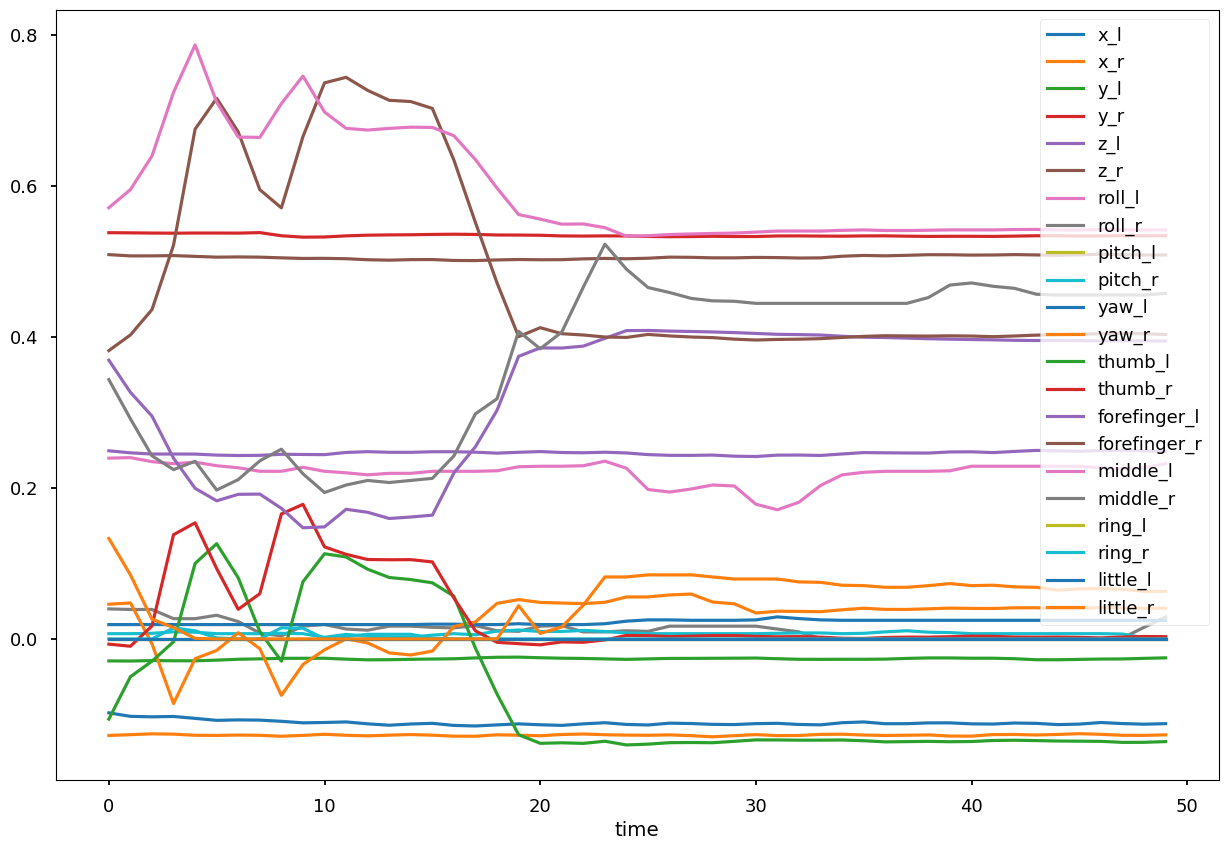

In [ ]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные по [ссылке](https://cloud.mail.ru/public/XcJu/qgrP6b2XX), но при желании вы можете повторить вычисления.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters

# df_database['id'] = df_database['id'].astype(object)
# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features.index = sign_classes.index
# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [ ]:
!mkdir ./data
!wget 'https://www.dropbox.com/s/3aiivwb28gdoxj8/tsfresh_features_filt.csv.gz?dl=0' -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

mkdir: cannot create directory ‘./data’: File exists
--2023-04-28 18:28:03--  https://www.dropbox.com/s/3aiivwb28gdoxj8/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/3aiivwb28gdoxj8/tsfresh_features_filt.csv.gz [following]
--2023-04-28 18:28:03--  https://www.dropbox.com/s/raw/3aiivwb28gdoxj8/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44ff573c5453a07ca2d0df9417.dl.dropboxusercontent.com/cd/0/inline/B7BQVyTeV3sfxGvXE8ARgO0lejVeVzdL8mmO3v-NQ-LdSIySjmlKESuwsmg6Fw27jzLlRlSOx0amzXcjVa0ilotz8XfREE5dOacxbL9LyuOEk6UufMcbq6pbzwnzBPIm487Wzk0ujniF8Ly4Jh-o222tu5W1ruNEh4IQL4xzNBhYIw/file# [following]
--2023-04-28 18:28:04--  https://uc44ff573c5453a07ca2d0df9417.dl.dropboxus

In [ ]:
sign_features_filtered.shape

(2565, 11452)

In [ ]:
sign_features_filtered.head()

,id,ring_r__absolute_maximum,ring_r__maximum,ring_r__mean_n_absolute_max__number_of_maxima_7,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",...,"middle_l__fft_coefficient__attr_""angle""__coeff_48","middle_l__fft_coefficient__attr_""angle""__coeff_49","middle_l__fft_coefficient__attr_""angle""__coeff_50","middle_r__fft_coefficient__attr_""real""__coeff_34","middle_r__fft_coefficient__attr_""real""__coeff_35","middle_r__fft_coefficient__attr_""real""__coeff_36","middle_r__fft_coefficient__attr_""real""__coeff_37","middle_r__fft_coefficient__attr_""real""__coeff_38","middle_r__fft_coefficient__attr_""real""__coeff_40","middle_r__fft_coefficient__attr_""real""__coeff_43"
0,0,0.014764,0.014764,0.010414,0.998626,0.000174,0.047854,0.000034,0.006166,0.000423,...,0.0,113.688081,117.543722,0.075507,0.076256,0.064602,0.103978,0.0884,0.063342,0.095416
1,1,0.017579,0.017579,0.008633,0.017579,0.000180,0.045183,0.000027,0.003599,0.000397,...,0.0,113.688081,117.543722,0.075507,0.076256,0.064602,0.103978,0.0884,0.063342,0.095416
2,2,0.043917,0.043917,0.033783,0.043917,0.000737,0.059952,0.000092,0.028252,0.001034,...,0.0,113.688081,117.543722,0.075507,0.076256,0.064602,0.103978,0.0884,0.063342,0.095416
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,113.688081,117.543722,0.075507,0.076256,0.064602,0.103978,0.0884,0.063342,0.095416
4,4,0.061037,0.061037,0.053199,0.061037,0.001453,0.402618,0.000127,0.047034,0.001777,...,0.0,113.688081,117.543722,0.075507,0.076256,0.064602,0.103978,0.0884,0.063342,0.095416


## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [ ]:
sign_classes

,class
id,
0,alive
1,alive
2,alive
3,all
4,all
...,...
2560,you
2561,you
2562,zero


In [ ]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes['class'].values

In [ ]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [ ]:
base_cv_scores.mean()

0.9200779727095517

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

In [ ]:
# Your Code Here
from sklearn.decomposition import PCA

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
my_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver="randomized", random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])
my_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(random_state=123, svd_solver='randomized')),
                ('clf', KNeighborsClassifier(n_neighbors=9))])

In [ ]:
cv_scores = cross_val_score(my_model, X, y, cv=cv, scoring='accuracy')
cv_scores.mean()

0.9200779727095517

Так как функция зависимости качества от количества компонент в PCA монотонно неубывающая, то для поиска числа компонент, при котором качество будет $>= 90 \% $, можно применить бинарный поиск, он отработает за $log_{2}(250```) \approx 7$ итераций

In [ ]:
l = 1
r = 250
while l < r:
    m = (l + r) // 2
    my_model.set_params(pca__n_components=m)
    m_result = cross_val_score(my_model, X, y, cv=cv, scoring='accuracy').mean()
    if m_result < 0.9:
        l = m + 1
    if m_result >= 0.9:
        r = m
print("n_components = ", l)
my_model.set_params(pca__n_components=l)
print("result = ", cross_val_score(my_model, X, y, cv=cv, scoring='accuracy').mean())
min_n_components = l

n_components =  82
result =  0.901364522417154


Доля объясненной дисперсии:  0.6316833954518091


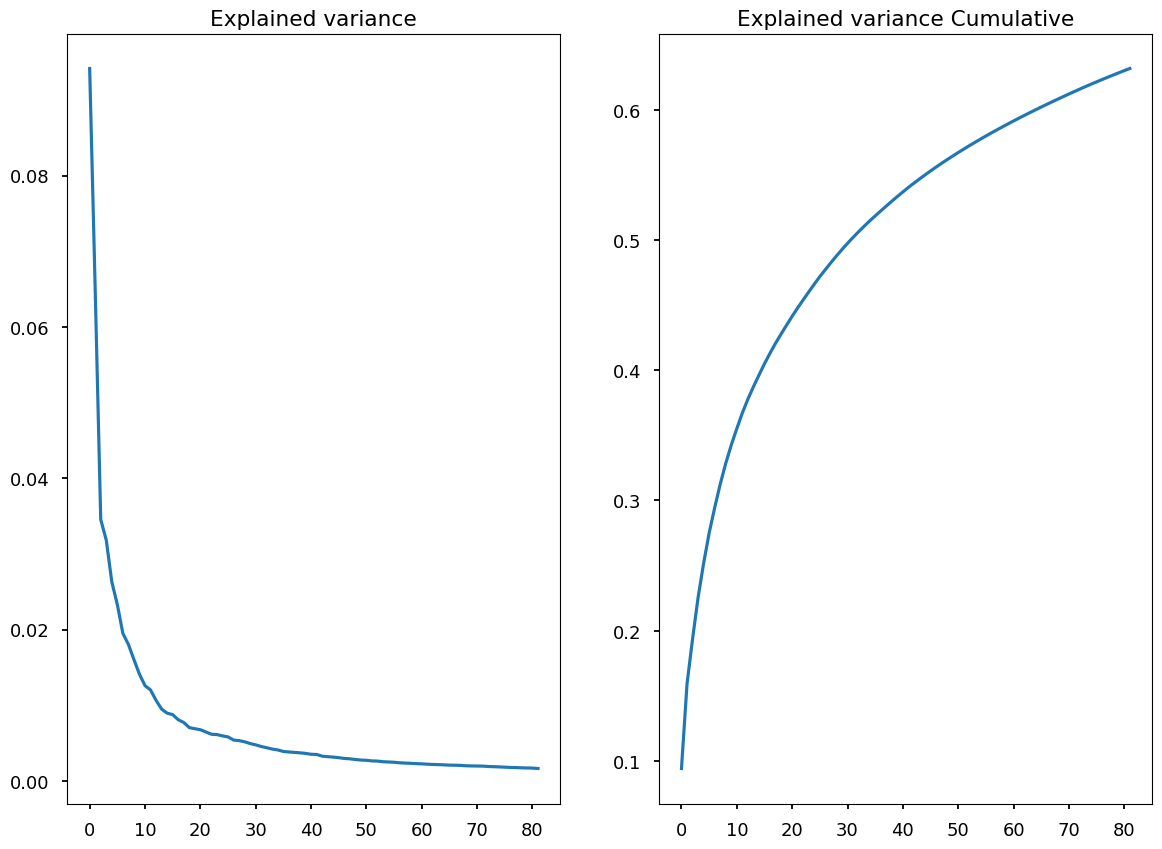

In [ ]:
my_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=min_n_components, svd_solver="randomized", random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

my_model.fit(X, y)
explained_variance_ratio = my_model.steps[1][1].explained_variance_ratio_
print("Доля объясненной дисперсии: ", explained_variance_ratio.sum())

fig, (ax1, ax2) = plt.subplots(figsize=(14, 10), ncols=2)
ax1.plot(explained_variance_ratio)
ax1.set_title("Explained variance")
ax2.plot(np.cumsum(explained_variance_ratio))
ax2.set_title("Explained variance Cumulative")
plt.show()

То есть PCA оставил у нас 63% вариативности данных

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [5]:
!mkdir ./data
!wget https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture06/data/news.csv -O ./data/news.csv

--2023-05-27 16:40:30--  https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture06/data/news.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13352242 (13M) [text/plain]
Saving to: ‘./data/news.csv’

./data/news.csv     100%[===================>]  12.73M  --.-KB/s    in 0.1s    

2023-05-27 16:40:31 (85.7 MB/s) - ‘./data/news.csv’ saved [13352242/13352242]



In [6]:
df = pd.read_csv('./data/news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [7]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [8]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [9]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)

In [12]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-27 16:40:58--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.242, 5.45.205.243, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2023-05-27 16:40:59--  http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)... 37.9.93.113, 2a02:6b8:117:5::113
Connecting to cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)|37.9.93.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [applica

In [13]:
# !wget http://download.cdn.yandex.net/mystem/mystem-3.1-macosx.tar.gz
# !tar -xvf mystem-3.1-macosx.tar.gz

In [14]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 7.61 s, sys: 222 ms, total: 7.83 s
Wall time: 57.4 s


In [15]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [16]:
df.text[0] # так выгладит первая статья после предобработки

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [17]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [18]:
vect = TfidfVectorizer()
texts = df.text.values

In [19]:
X = vect.fit_transform(texts)

In [20]:
S = pairwise_distances(X, metric='cosine')

[[Text(0.5, 0, ''),
  Text(57.5, 0, ''),
  Text(114.5, 0, ''),
  Text(171.5, 0, ''),
  Text(228.5, 0, ''),
  Text(285.5, 0, ''),
  Text(342.5, 0, ''),
  Text(399.5, 0, ''),
  Text(456.5, 0, ''),
  Text(513.5, 0, ''),
  Text(570.5, 0, ''),
  Text(627.5, 0, ''),
  Text(684.5, 0, ''),
  Text(741.5, 0, ''),
  Text(798.5, 0, ''),
  Text(855.5, 0, ''),
  Text(912.5, 0, ''),
  Text(969.5, 0, ''),
  Text(1026.5, 0, ''),
  Text(1083.5, 0, ''),
  Text(1140.5, 0, ''),
  Text(1197.5, 0, ''),
  Text(1254.5, 0, ''),
  Text(1311.5, 0, ''),
  Text(1368.5, 0, ''),
  Text(1425.5, 0, ''),
  Text(1482.5, 0, ''),
  Text(1539.5, 0, ''),
  Text(1596.5, 0, ''),
  Text(1653.5, 0, ''),
  Text(1710.5, 0, ''),
  Text(1767.5, 0, ''),
  Text(1824.5, 0, ''),
  Text(1881.5, 0, '')],
 [Text(0, 0.5, ''),
  Text(0, 46.5, ''),
  Text(0, 92.5, ''),
  Text(0, 138.5, ''),
  Text(0, 184.5, ''),
  Text(0, 230.5, ''),
  Text(0, 276.5, ''),
  Text(0, 322.5, ''),
  Text(0, 368.5, ''),
  Text(0, 414.5, ''),
  Text(0, 460.5, ''),


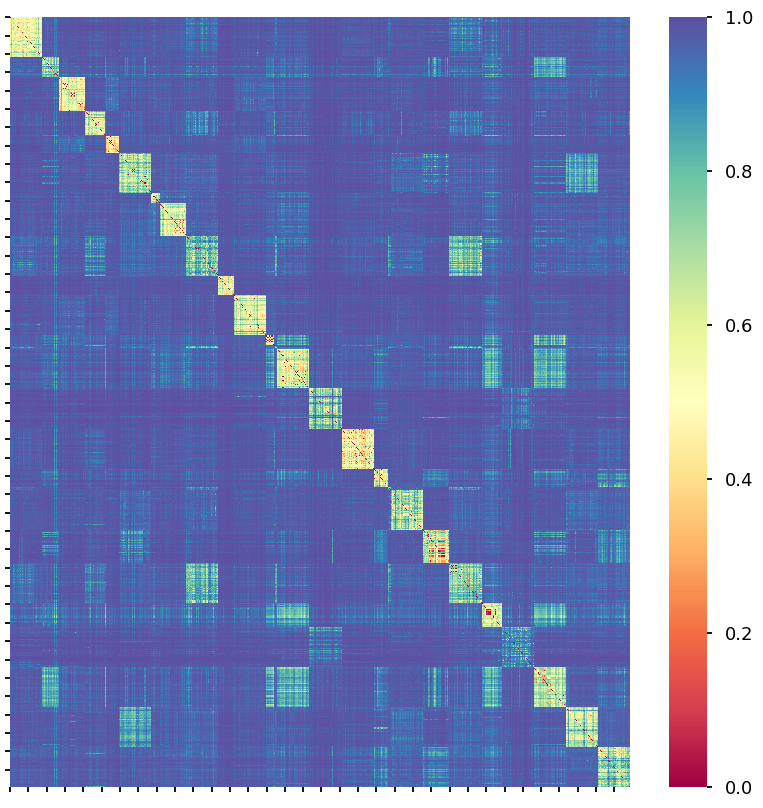

In [21]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])


Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [22]:
# Your Code Here
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

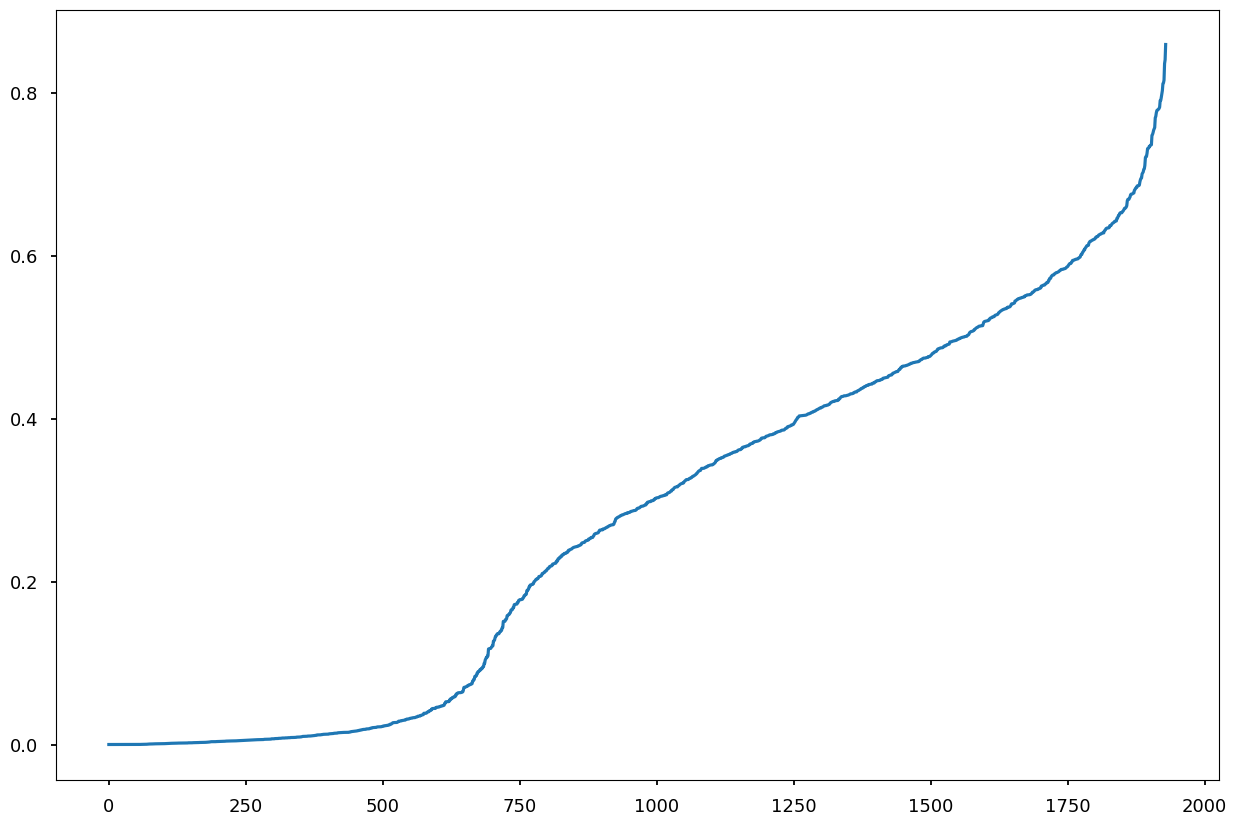

In [23]:
docs = vect.fit_transform(texts)

def find_eps(df):
  nn = NearestNeighbors(n_neighbors=8, metric='cosine')
  res = nn.fit(df)
  dist, i = res.kneighbors(df)
  dist = np.sort(dist, axis=0)
  dist = dist[:,1]
  plt.plot(dist)
  plt.show()

find_eps(docs)

In [24]:
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='cosine')
dbscan.fit(docs)
labels = dbscan.labels_
pred = df.assign(pred_labels = labels)
true_label = df['class']

In [25]:
tmp_df = pd.read_csv('./data/news.csv', encoding='utf8')
tmp_texts = np.array(tmp_df.text)

for i in range(0, max(labels)):
    print("-" * 40)
    print("Label =", i)
    print("Example text:")
    print(tmp_texts[np.where(labels == i)][3])
    print("-" * 40)
    print('\n\n')

----------------------------------------
Label = 0
Example text:
 Google Новости ТОП, Москва, 14 января 2017 АКЦИЯ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ ПРОШЛА БЕЗ НАРУШЕНИЙ Москва. 13 января. INTERFAX.RU - Акция противников передачи Исаакиевского собора Русской православной церкви прошла без нарушений, сообщили "Интерфаксу" в пятницу в пресс-службе управления МВД по Санкт-Петербургу и Ленинградской области. "Общественная акция рядом... http://www.interfax.ru/russia/545283#googletop
----------------------------------------



----------------------------------------
Label = 1
Example text:
 Дэлайт новости (delate.info), Москва, 21 января 2017 ИНАУГУРАЦИЯ ТРАМПА ОНЛАЙН: ДАТА И ВРЕМЯ ПО МОСКВЕ, КОГДА СМОТРЕТЬ ПРЯМУЮ ТРАНСЛЯЦИЮ, СПИСОК ГОСТЕЙ, КТО БУДЕТ ОТ РОССИИ Дональд Трамп Инаугурация Трампа онлайн: дата и время по Москве, когда смотреть прямую трансляцию, список гостей и кто будет от России, интересует многих читателей. Все волнительно ждут момента, чтобы услышать текст присяги ам

Cкорее всего кластер: 

*   0 - Политика РФ
*   1 - Мировая политика
*   2 - Культура
*   3 - Криминал или про оппозицию
*   4 - Мировая политика
*   5 - Теракты
*   6 - Международные отношения
*   7 - Криминал
*   8 - Оппозиция
*   9 - Технологии
*   10 - Культура
*   11 - Международные отношения
*   12 - Спорт
*   13 - Политика РФ
*   14 - Мировая политика
*   15 - Проишествия
*   16 - Теракт



In [26]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
class,,,,,,,,,,,,,,,,,,,
Важные мировые события,29,0,28,84,0,41,0,0,0,0,0,0,98,0,0,123,0,0,0
Внутренняя политика РФ,15,99,0,0,0,0,0,0,0,0,0,0,62,0,100,0,0,0,88
Внутренняя политика РФ: оппозиция,85,0,0,0,59,0,0,0,0,133,0,0,0,0,0,0,0,0,0
Внутренняя политика: культура,8,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,0,0,0
Международные отношения,6,0,0,0,0,0,0,26,0,0,0,0,121,0,0,0,0,0,0
Международные отношения: Криминальная хроника,3,0,0,0,0,0,0,0,79,0,0,0,0,0,0,0,0,0,0
Проишествия РФ,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,98,0,0
Спорт,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Спорт,28,0,0,0,0,0,0,0,0,0,0,0,0,74,0,0,0,0,0


In [ ]:
adjusted_rand_score(true_label, labels)

0.3796459910720631